In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 14 00:59:43 2019

@author: MichaelRolleigh
"""
# This script enacts the crossover strategy in bt

import bt
# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')

# calculate moving average DataFrame using pandas' rolling_mean
import pandas as pd

# define the length of the short and long averages
short = 50
long = 200

# a rolling mean is a moving average, right?
sma_short = data.rolling(short).mean()
sma_long = data.rolling(long).mean()

# and compute sma_50 for replicating earlier strat
sma_50 = data.rolling(50).mean()

# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = bt.merge(data, sma_short, sma_long).plot(figsize=(15, 5))

# We need to set up our target weights. This will be the same size as sma_long
# weight = 1 means go long; weight = -1 means short

target_weights = sma_long.copy()


# set appropriate target weights
target_weights[sma_short > sma_long] =  0.2
target_weights[sma_short <= sma_long] = -0.2
# Why are the weights 0.2 and -0.2 (20%) instead of 1 (100%)?


# Now set up the MA_cross strategy for our moving average cross strategy
MA_cross = bt.Strategy('MA_cross', [bt.algos.WeighTarget(target_weights),
                                    bt.algos.Rebalance()])

test_MA = bt.Backtest(MA_cross, data)
res_MA = bt.run(test_MA)

# plot security weights to test logic
res_MA.plot_security_weights()


# define a signal to feed to the SelectWhere class to select securities to trade
# The signal is simple, data>sma_50 because data is price and sma_50 is moving average
signal = data > sma_50
bt.algos.SelectWhere(signal, include_no_data=False)

# first we create the Strategy
s = bt.Strategy('above50sma', [bt.algos.SelectWhere(signal),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t, test_MA)

# what does the equity curve look like?
res.plot()

# and some performance stats
res.display()

# Now create a function that will allow us to generate related backtests more quickly
# This step is not required, but it is good programming practice
# I do not use these functions in this simple example, but they would be very useful
# if we were trying to pitimize our parameters
def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [bt.algos.SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)

# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)



Stat                 above50sma    MA_cross
-------------------  ------------  ----------
Start                2010-01-03    2010-01-03
End                  2021-06-04    2021-06-04
Risk-free rate       0.00%         0.00%

Total Return         176.55%       58.13%
Daily Sharpe         0.55          0.31
Daily Sortino        0.84          0.47
CAGR                 9.32%         4.10%
Max Drawdown         -39.43%       -46.09%
Calmar Ratio         0.24          0.09

MTD                  1.19%         1.39%
3m                   5.26%         11.02%
6m                   22.60%        28.70%
YTD                  16.56%        23.58%
1Y                   42.51%        41.69%
3Y (ann.)            11.70%        -2.73%
5Y (ann.)            15.48%        6.21%
10Y (ann.)           12.89%        4.81%
Since Incep. (ann.)  9.32%         4.10%

Daily Sharpe         0.55          0.31
Daily Sortino        0.84          0.47
Daily Mean (ann.)    10.85%        5.64%
Daily Vol (ann.)     19.60%      

<AxesSubplot:xlabel='Date'>

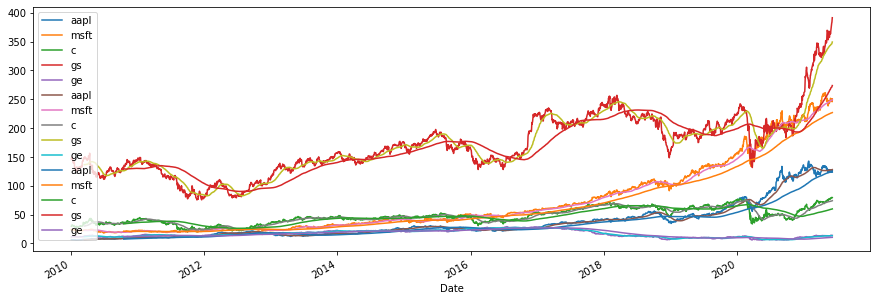

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
bt.merge(data, sma_short, sma_long).plot(figsize=(15, 5))